In [1]:
%pip install requests
%pip install jieba
%pip install matplotlib
%pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests

In [3]:
# get word frequency list

def parse_word(e):
    l = e.split(" ")
    if len(l) < 3:
        print("malformed entry:", l)
        return {"rank": 0, "freq": "0", "word": l[0]}
    return {
        "rank": int(l[0]),
        "freq": float(l[1]),
        "word": l[2],
    }

r = requests.get("http://corpus.leeds.ac.uk/frqc/internet-zh.num")
word_freq = list(map(parse_word, r.text.split("\n")[4:-1]))
print(len(word_freq), "words retrieved")

50000 words retrieved


In [4]:
%%bash
# download example sentences with translations
wget "http://www.manythings.org/anki/cmn-eng.zip" -O cmn-eng.zip 2>&1 | grep ERROR
unzip -oq cmn-eng.zip -d cmn-eng && echo "done"

done


In [5]:
# parse example sentences file

def parse_example(e):
    l = e[:-1].split("\t")
    return {
        "cmn": l[1],
        "eng": l[0],
        "attr": l[2],
        "dup": False
    }

with open("cmn-eng/cmn.txt") as f:
    lines = f.readlines()
    
sentences = list(map(parse_example, lines))
print(len(sentences), "sentences retrieved")

translations = {}
for i in range(len(sentences)):
    if not sentences[i]["cmn"] in translations:
        translations[sentences[i]["cmn"]] = []
    else:
        sentences[i]["dup"] = True
    translations[sentences[i]["cmn"]].append(i)

29476 sentences retrieved


In [6]:
def get_word_rank(word):
    if word in word_map:
        return word_map[word]["rank"]
    else:
        rank = 0
        for c in word:
            if c in word_map:
                rank = max(rank, word_map[c]["rank"])
            else:
                return len(word_freq)
        return rank

In [7]:
# cut sentences into words, and more

import jieba

word_map = {}
for i in range(len(word_freq)):
    word_map[word_freq[i]["word"]] = {
        "rank": word_freq[i]["rank"],
        "freq": word_freq[i]["freq"],
        "sentences": [] # indices of sentences which contain this word
    }

always_use_char_freq = True # if this is false, then character frequency is used only as a fallback when none of the words are on the frequency list
    
# for i in range(len(sentences)):
#     sentences[i]["words"] = jieba.lcut(sentences[i]["cmn"])
#     sentences[i]["wc"] = len(sentences[i]["words"]) # word count
#     sentences[i]["maxrank"] = -1 # rank of the least common word
#     ranks = []
#     for word in sentences[i]["words"]:
#         if word in word_map:
#             word_map[word]["sentences"].append(i)
#             sentences[i]["maxrank"] = max(sentences[i]["maxrank"], word_map[word]["rank"])
#             ranks.append(word_map[word]["rank"])
#     if always_use_char_freq or sentences[i]["maxrank"] == -1: # fallback: check for character frequency
#         if sentences[i]["maxrank"] == -1:
#             sentences[i]["maxrank"] = len(word_freq)
#         for word in list(sentences[i]["cmn"]):
#             if word in word_map:
#                 word_map[word]["sentences"].append(i)
#                 #sentences[i]["maxrank"] = max(sentences[i]["maxrank"], word_map[word]["rank"])
#                 ranks.append(word_map[word]["rank"])
#     if len(ranks) > 0:
#         sentences[i]["avgrank"] = sum(ranks) / len(ranks)
#     if sentences[i]["maxrank"] == -1:
#         print("Couldn't determine maxrank for sentence", i, sentences[i]["words"], sentences[i]["eng"])
#         sentences[i]["maxrank"] = len(word_freq)
#         sentences[i]["avgrank"] = sentences[i]["maxrank"]

for i in range(len(sentences)):
    sentences[i]["words"] = jieba.lcut(sentences[i]["cmn"])
    sentences[i]["wc"] = len(sentences[i]["words"]) # word count
    ranks = []
    for word in sentences[i]["words"]:
        ranks.append(get_word_rank(word))
        if word in word_map:
            word_map[word]["sentences"].append(i)
    assert len(ranks) > 0
    sentences[i]["maxrank"] = max(ranks)
    sentences[i]["avgrank"] = sum(ranks) / len(ranks)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.536 seconds.
Prefix dict has been built successfully.


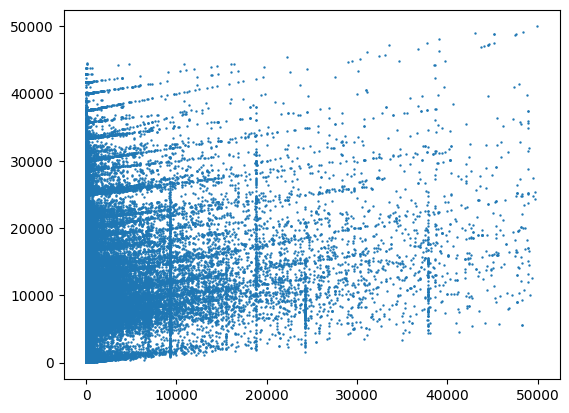

In [8]:
import matplotlib.pyplot as plt

xs = []
ys = []

for i in range(len(word_freq)):
    for sid in word_map[word_freq[i]["word"]]["sentences"]:
        xs.append(word_freq[i]["rank"])
        ys.append(sentences[sid]["avgrank"])
    
fig, ax = plt.subplots()
ax.scatter(xs, ys, s=0.5)
plt.show()

In [9]:
# a test for sentence selection

sent = []
wid = 1000 #236
for sid in word_map[word_freq[wid]["word"]]["sentences"]:
    sent.append(sid)
    
sent.sort(key=(lambda sid : sentences[sid]["maxrank"]*len(word_freq) - sentences[sid]["avgrank"]*sentences[sid]["wc"]))
    
print("("+str(word_freq[wid]["rank"]), word_freq[wid]["word"]+")\nmax\tavg\twc\tavg*wc")    
for sid in sent:
    if not sentences[sid]["dup"]:
        print(sentences[sid]["maxrank"], "%.2f" % sentences[sid]["avgrank"], sentences[sid]["wc"], int(sentences[sid]["avgrank"])*sentences[sid]["wc"], sentences[sid]["cmn"], "\n\t\t\t\t\t\t\t"+sentences[sid]["eng"], sep="\t")

(1001 支)
max	avg	wc	avg*wc
5381	1137.14	7	7959	能借我支铅笔吗？	
							Would you lend me a pencil?
5381	1140.17	6	6840	你有多少支铅笔？	
							How many pens do you have?
50000	13621.25	8	108968	我比你多10支钢笔。	
							I have ten pens more than you do.
50000	12217.33	6	73302	你有多少支球拍?	
							How many rackets do you have?
50000	9401.17	6	56406	给我支香烟吧。	
							Give me a cigarette.


In [10]:
# first method for card creation

cards = []
count = 0
for word in word_freq:
    sent = []
    for sid in word_map[word["word"]]["sentences"]:
        sent.append(sid)

    sent.sort(key=(lambda sid : sentences[sid]["maxrank"]*len(word_freq) - sentences[sid]["avgrank"]*sentences[sid]["wc"]))
    
    if len(sent) == 0:
        pass
        # print("no example sentences for word", word)
    else:
        sid = sent[0]
        if sentences[sid]["maxrank"] <= word["rank"] + 10 or (sentences[sid]["maxrank"] <= 120 and word["rank"] < 100) or (sentences[sid]["avgrank"] < word["rank"]/2):
            count += 1
            print("%3d|" % word["rank"], "%-3s\t" % word["word"], "+%d" % (sentences[sid]["maxrank"]-word["rank"]), "\t",
                  sentences[sid]["maxrank"], "\t%.2f\t" % sentences[sid]["avgrank"],
                  sentences[sid]["cmn"], sentences[sid]["eng"])
print(count, "/", len(word_freq), "=", 100*count/len(word_freq), "%")

  1| ，  	 +100 	 101 	33.86	 那不对，对吧？ That isn't true, is it?
  2| 的  	 +58 	 60 	19.50	 你说的是什么？ What are you talking about?
  3| 了  	 +54 	 57 	18.60	 你想我了？ Do you miss me?
  4| 我  	 +53 	 57 	18.60	 你想我了？ Do you miss me?
  6| 在  	 +54 	 60 	26.00	 你在看什么？ What're you reading?
  7| 是  	 +53 	 60 	32.25	 那是什么？ What's that?
  9| 他  	 +51 	 60 	21.80	 他说了什么？ What did he say?
 11| 你  	 +46 	 57 	18.60	 你想我了？ Do you miss me?
 13| 不  	 +88 	 101 	33.86	 那不对，对吧？ That isn't true, is it?
 14| 有  	 +96 	 110 	40.83	 有什么不对吗？ Is something wrong?
 16| 这  	 +94 	 110 	35.88	 这是对的，不是吗？ That's right, isn't it?
 18| ？  	 +39 	 57 	18.60	 你想我了？ Do you miss me?
 19| 说  	 +41 	 60 	28.43	 你想对我说什么？ What do you want to tell me?
 21| 她  	 +39 	 60 	24.20	 她说了什么？ What did she say?
 23| 都  	 +90 	 113 	50.40	 什么问题都没有！ No problem at all!
 24| ！  	 +6 	 30 	27.00	 对！ That's right.
 25| 我们 	 +59 	 84 	37.67	 你要我们做什么？ What did you want us to do?
 28| 要  	 +56 	 84 	37.67	 你要我们做什么？ What did you want us to do?
 30| 对

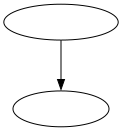

In [11]:
import graphviz

g = graphviz.Digraph("g", strict=True, engine="dot")
#for i in range(20):
#    g.node(word_freq[i]["word"])

ignored = {}
ignored["。"] = True
ignored["！"] = True
ignored["!"] = True
ignored["？"] = True
    
# for i in range(100):
#     for word in sentences[i]["words"]:
#         if not word in ignored:
#             g.edge(sentences[i]["cmn"], word)
#             if len(word) != 1:
#                 for c in word:
#                     if not c in ignored:
#                         g.edge(word, c)

# n = 1000
# for i in range(n):
#     for j in range(n):
#         sim = 0
#         dif = 0
#         dw = " "
#         for word in sentences[i]["words"]:
#             if not word in ignored:
#                 if word in sentences[j]["words"]:
#                     sim += 1
#                 else:
#                     dif += 1
#                     dw = word
#         for word in sentences[j]["words"]:
#             if not word in ignored:
#                 if not word in sentences[i]["words"]:
#                     dif = 100
#                     break
#         if dif == 1:
#             g.edge(sentences[i]["cmn"], sentences[j]["cmn"], label=dw)

n = 20
for i in range(n):
    for j in range(n):
        sim = 0
        dif = 0
        dw = " "
        for word in sentences[i]["words"]:
            if not word in ignored:
                if word in sentences[j]["words"]:
                    sim += 1
                else:
                    dif += 1
                    dw = word
        for word in sentences[j]["words"]:
            if not word in ignored:
                if not word in sentences[i]["words"]:
                    dif = 100
                    break
        if dif == 1:
            g.edge(sentences[i]["cmn"], sentences[j]["cmn"], label=dw)

g